In [1]:
import pandas as pd
import numpy as np
import os.path
from os import path
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

pd.set_option('display.max_rows', 500)

In [2]:
contributions = pd.read_csv("jira-contribution.csv.gz")
contributions.date = pd.to_datetime(contributions.date * 1000000, utc = True)

Latest record from the dataset:

In [3]:
contributions.sort_values("date", ascending=False).head(1)
# contributions = contributions[contributions.date > '2020-06-01']

,project,type,identifier,subidentifier,date,author,owner
15540,HDDS,JIRA_CREATED,HDDS-4891,NaN,2021-03-02 12:33:41+00:00,adoroszlai,adoroszlai


# Github Contributions per user


In [4]:
c = contributions[["identifier","author","type","owner"]].groupby(["author","type","owner"]).count() \
   .reset_index().rename(columns={"identifier":"contributions"})
#contributions per user
c[c.author != c.owner][["author","contributions"]].groupby("author").sum().sort_values("contributions",ascending=False).head(10)


,contributions
author,
hadoopqa,1853
hudson,1491
anu,1103
genericqa,864
elek,675
ppogde,627
arpitagarwal,603
xyao,541
bharatviswa,524


## Contributors per participations in JIRA which are not created by self (commenting/helping JIRA)

In [5]:
c = contributions[contributions.author != contributions.owner][["identifier","author"]].groupby(["identifier","author"]).count() \
   .reset_index().groupby("author").count()
c.sort_values("identifier",ascending=False).head(20)

,identifier
author,
hudson,1408
hadoopqa,684
ppogde,622
anu,616
arpitagarwal,388
elek,328
xyao,326
genericqa,259
nandakumar131,243


## Contributors per participations in any issue

In [6]:
c = contributions[["identifier","author"]].groupby(["identifier","author"]).count() \
   .reset_index().groupby("author").count()
c.sort_values("identifier",ascending=False).head(20)

,identifier
author,
hudson,1408
elek,896
anu,721
hadoopqa,684
ppogde,678
bharatviswa,609
xyao,528
adoroszlai,519
msingh,503


# Bus factor (number of contributors responsible for the 50% of the prs) from last half year

## Contributors until the half of the all contributions

In [7]:
prcreated = contributions[contributions.type == "JIRA_CREATED"]
prcreated = prcreated[prcreated.date > (datetime.datetime.now() - datetime.timedelta(days=182)).strftime('%Y-%m-%d')]
prcreated = prcreated[["identifier"]].groupby(prcreated.author).count().reset_index()
prcreated = prcreated.sort_values("identifier", ascending=False)
prcreated = prcreated.reset_index(drop=True)
prcreated["cs"] = prcreated["identifier"].cumsum()
prcreated["ratio"]= prcreated.identifier / prcreated.identifier.sum()  * 100
prcreated[prcreated.cs < prcreated.identifier.sum() / 2]

,author,identifier,cs,ratio
0,adoroszlai,74,74,10.616930
1,elek,60,134,8.608321
2,amaliujia,40,174,5.738881
3,glengeng,35,209,5.021521
4,rakeshr,34,243,4.878049
5,avijayan,28,271,4.017217
6,jojochuang,28,299,4.017217
7,bharatviswa,27,326,3.873745


## Pony number (bus factor)

In [8]:
pn = (prcreated[prcreated.cs < prcreated.identifier.sum() / 2]).shape[0] + 1
pn

9

## Dev power (All the contributions in the ration of the top contributor)

In [9]:
prcreated["power"] = prcreated["identifier"] / prcreated.reset_index()["identifier"][0] 
prcreated.power.sum()

9.41891891891892

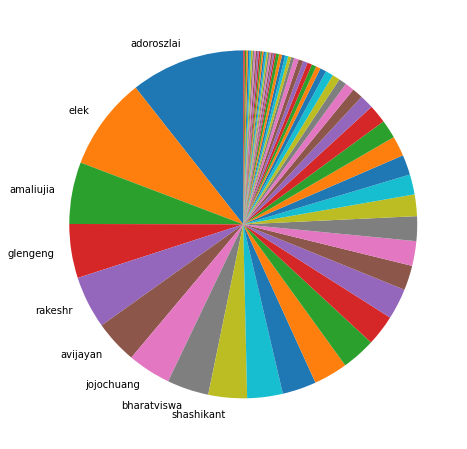

In [10]:
labels = np.asarray(prcreated["author"])
for i in range(pn,len(labels)):
    labels[i] = ""
plt.figure(figsize=(10,8))
plt.pie(prcreated["ratio"], labels=labels, startangle=90)
plt.show()


## People with created JIRAs > commented JIRA

In [11]:
created = contributions[contributions.type == "JIRA_CREATED"][["author","identifier"]].groupby("author").count().rename(columns={"identifier":"created"})
helped = contributions[contributions.author != contributions.owner][["identifier"]].groupby([contributions.author,contributions.identifier]).sum().rename(columns={"identifier":"helped"}) \
  .reset_index().groupby(["author"]).count().drop(columns=["identifier"])
merged = pd.merge(helped,created, left_index=True, right_index=True)

# merged.index = merged.index.rename("githubname")
# merged = merged.join(github_apache_membership.set_index("githubname")).reset_index()
# merged.role = merged.role.fillna("?")
# merged["rc"] = merged.role.map({"pmc":"red","committer":"yellow","?":"blue"})
merged = merged.reset_index()

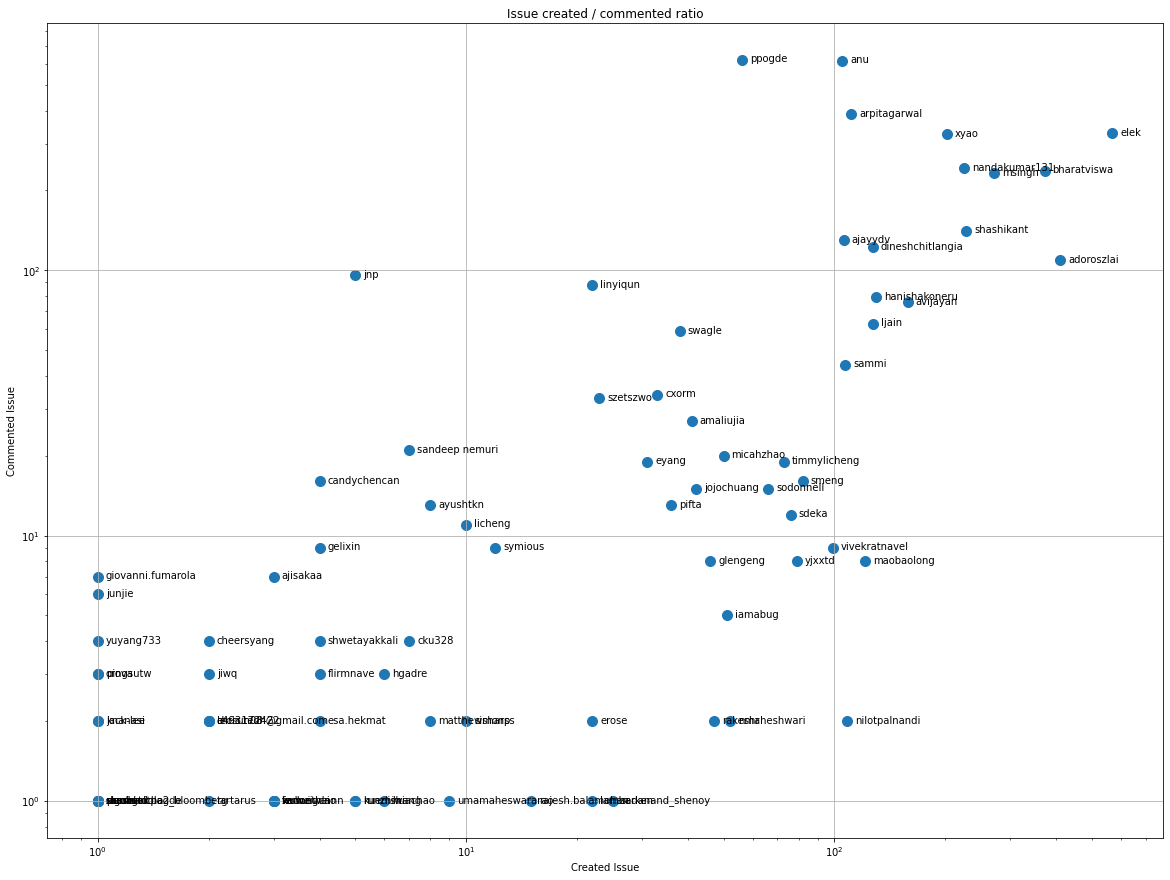

In [12]:
source = merged.reset_index()

plt.figure(figsize=(20,15))

plt.scatter(source.created,source.helped, s= 100)

plt.xlabel('Created Issue')
plt.ylabel('Commented Issue')
plt.title('Issue created / commented ratio')
plt.grid()

for index, row in source.iterrows():
     plt.annotate(row["author"], (row["created"], row["helped"]), xytext=(8,-2), textcoords='offset points')
plt.semilogx()
plt.semilogy()
plt.show()

## Same graph with focusing to the last 6 month

Only contributors with both created pr and helped pr visible

In [13]:
import datetime

filtered = contributions[contributions.date > (datetime.datetime.now() - datetime.timedelta(days=182)).strftime('%Y-%m-%d')]
created = filtered[filtered.type == "JIRA_CREATED"][["author","identifier"]].groupby("author").count().rename(columns={"identifier":"created"})
helped = filtered[filtered.author != filtered.owner][["identifier"]].groupby([filtered.author,filtered.identifier]).sum().rename(columns={"identifier":"helped"}) \
  .reset_index().groupby(["author"]).count().drop(columns=["identifier"])
merged = pd.merge(helped,created,left_index=True, right_index=True)
merged = merged.reset_index()

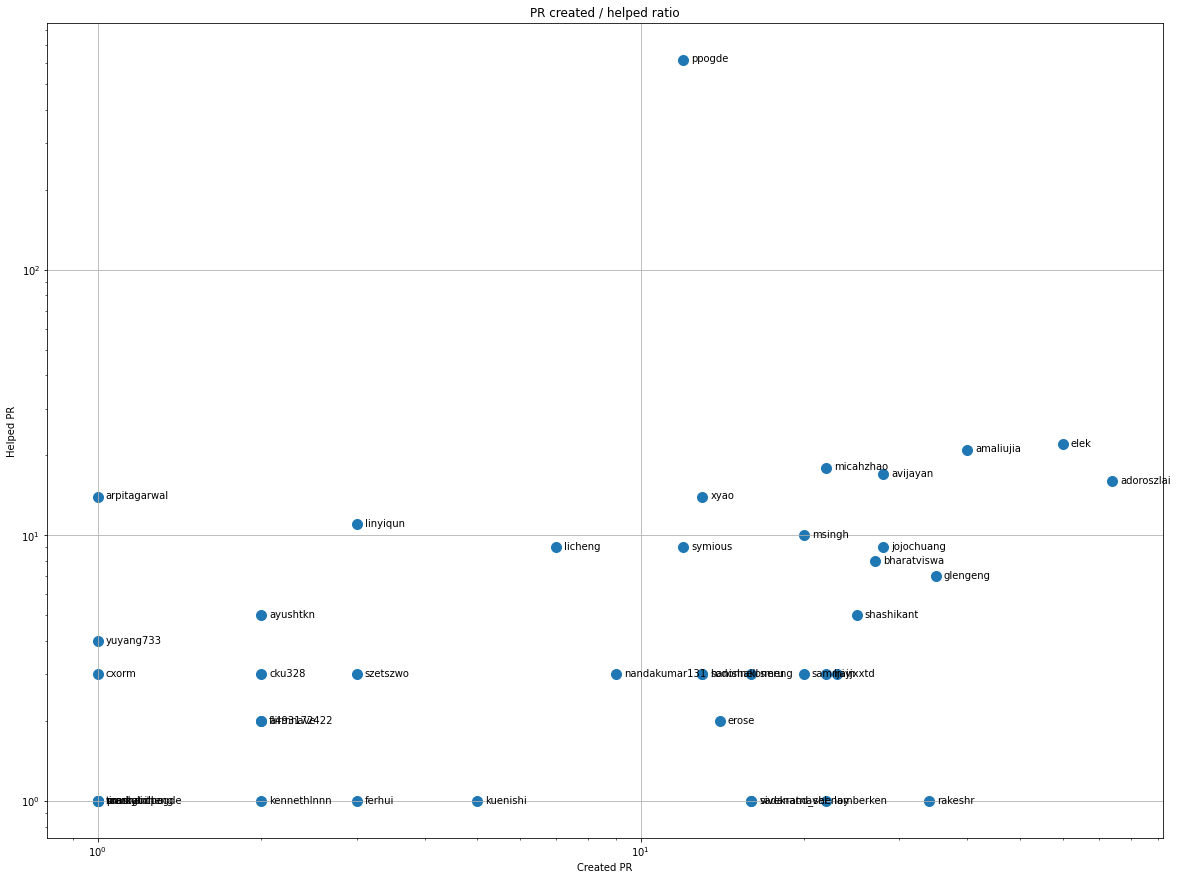

In [14]:
source = merged.reset_index()

plt.figure(figsize=(20,15))

plt.scatter(source.created,source.helped, s= 100)

plt.xlabel('Created PR')
plt.ylabel('Helped PR')
plt.title('PR created / helped ratio')
plt.grid()

for index, row in source.iterrows():
    plt.annotate(row["author"], (row["created"], row["helped"]), xytext=(8,-2), textcoords='offset points')
        
plt.semilogx()
plt.semilogy()
plt.show()


# Number of individual contributors per month

Number of different Jira users who either created ssue or commented Issue


In [15]:


m = contributions[["identifier"]].groupby([contributions.date.dt.strftime('%Y').rename("year"),contributions.date.dt.strftime('%m').rename("month"),contributions.author]).count() \
  .reset_index()
m

result = m[["author"]].groupby([m.year,m.month]).count().sort_values(["year","month"]).reset_index()
result = result.pivot(index="year",columns="month",values="author").fillna(0)


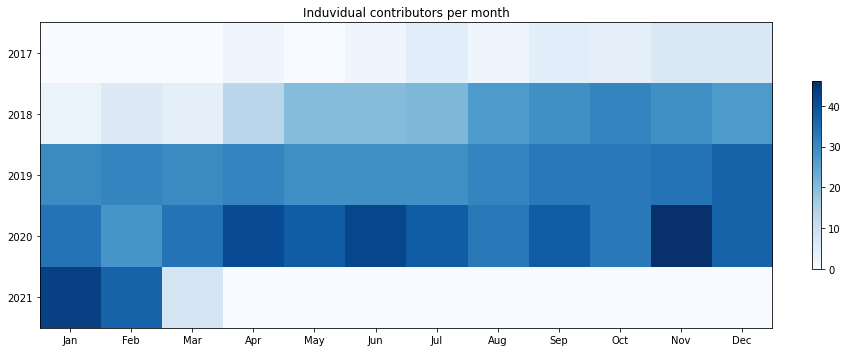

In [16]:
plt.figure(figsize=(14,11))
im = plt.imshow(result, cmap="Blues")
plt.yticks(range(len(result)),result.index.values)
plt.xticks(range(12), ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"])
plt.title("Induvidual contributors per month")
plt.colorbar(im, fraction=0.012)
plt.show()


# JIRA activity heatmap

In [17]:
days = contributions.date.dt.strftime('%A')
hours = contributions.date.dt.strftime('%H')

a = contributions[["date"]].groupby([days,hours]).count()
a.columns = ["count"]
a.index.names = ["day","hour"]
a = a.reset_index()
a = a.pivot(index="day",columns="hour",values="count")
a = a.reindex(["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"])


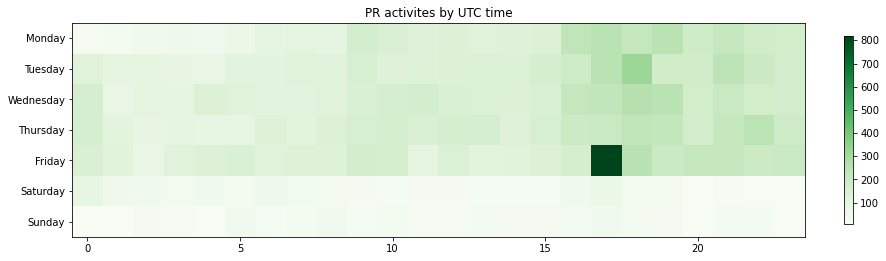

In [18]:
plt.figure(figsize=(14,11))
im = plt.imshow(a, cmap="Greens")
plt.yticks(range(len(a)),a.index.values)
plt.title("PR activites by UTC time")
plt.colorbar(im, fraction=0.012)
plt.show()
